In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import plotly.express as px
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [310]:
# Set the display format for floating-point numbers
pd.options.display.float_format = '{:.2f}'.format

In [311]:
file_1 = "C:/Users/Efrem/Downloads/meesho_statement_2/DICE Challenge Business Analytics Case 2/clicks__data.csv"
file_2 = "C:/Users/Efrem/Downloads/meesho_statement_2/DICE Challenge Business Analytics Case 2/views__data.csv"
file_3 = "C:/Users/Efrem/Downloads/meesho_statement_2/DICE Challenge Business Analytics Case 2/orders__table.csv"

In [312]:
click_data = pd.read_csv(file_1)
view_data = pd.read_csv(file_2)
order_data = pd.read_csv(file_3)

In [313]:
data = order_data.copy()
data['clicks_count'] = click_data['clicks_count']
data['app_open_count'] = view_data['app_open_count']
data['order_date'] = pd.to_datetime(data['order_date'])
df = data.copy()
df2 = data.copy()
data

,order_id,order_date,user_id,order_value,category,quantity,order_status,supplier_id,feedback,clicks_count,app_open_count
0,0,2023-09-26,14225,4044.37,Home Goods,1,cancelled,565,Negative feedback,1,4
1,1,2024-09-08,19369,2969.24,Clothing,10,cancelled,222,Positive feedback,11,46
2,2,2024-03-08,339,4985.45,Electronics,2,cancelled,907,Neutral feedback,44,48
3,3,2023-11-26,19310,4328.57,Clothing,4,delivered,176,Neutral feedback,37,42
4,4,2023-11-20,13523,2517.05,Home Goods,1,delivered,207,Negative feedback,10,19
...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,2023-10-04,11904,896.17,Home Goods,9,cancelled,769,Negative feedback,16,35
999996,999996,2023-12-14,83686,828.17,Clothing,5,returned,968,Positive feedback,7,27
999997,999997,2024-07-09,37213,4156.44,Electronics,6,delivered,745,Neutral feedback,6,7
999998,999998,2024-08-17,99950,4931.21,Home Goods,6,exchanged,423,Negative feedback,5,8


In [314]:
# Create a new column to indicate if an order was returned
df['is_returned'] = df['order_status'].apply(lambda x: 1 if x == 'returned' or x == 'RTO' else 0)
df['returned'] = df['order_status'].apply(lambda x: 1 if x == 'returned' else 0)
df['RTO'] = df['order_status'].apply(lambda x: 1 if x == 'RTO' else 0)

# Calculate the number of returned orders per user
return_frequency_per_user = df.groupby('user_id')['is_returned'].sum().reset_index()
return_frequency_per_user.columns = ['user_id', 'return_frequency']

# Calculate the total number of orders per user
total_orders_per_user = df.groupby('user_id')['order_id'].count().reset_index()
total_orders_per_user.columns = ['user_id', 'total_orders']

# Merge the two DataFrames to calculate the return rate
return_rate_per_user = pd.merge(return_frequency_per_user, total_orders_per_user, on='user_id')

# Calculate return rate: number of returned orders / total orders
return_rate_per_user['return_rate'] = return_rate_per_user['return_frequency'] / return_rate_per_user['total_orders']

df['return_rate'] = return_rate_per_user['return_rate']

f1 = df.groupby('user_id')['returned'].sum().reset_index()
return_rate_per_user['returned'] = f1['returned']
f2 = df.groupby('user_id')['RTO'].sum().reset_index()
return_rate_per_user['RTO'] = f2['RTO']


# Display the result
return_rate_per_user


,user_id,return_frequency,total_orders,return_rate,returned,RTO
0,1,2,14,0.14,0,2
1,2,6,13,0.46,1,5
2,3,3,8,0.38,1,2
3,4,5,14,0.36,4,1
4,5,3,9,0.33,1,2
...,...,...,...,...,...,...
99984,99996,3,10,0.30,1,2
99985,99997,5,8,0.62,2,3
99986,99998,2,11,0.18,0,2
99987,99999,1,12,0.08,0,1


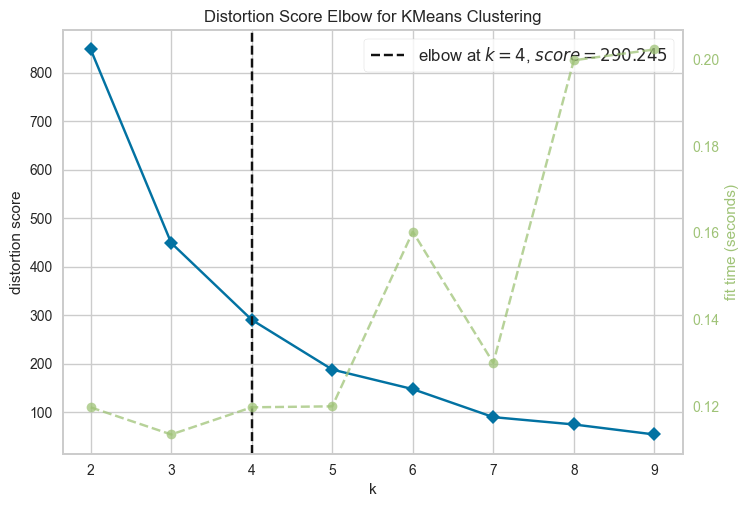

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [315]:
km = KMeans(random_state = 42)
visualizer = KElbowVisualizer(km, k = (2,10))
visualizer.fit(return_rate_per_user[['return_rate']])
visualizer.show()

In [316]:
data = return_rate_per_user
# Select the columns you want to apply KMeans on
columns = ['return_rate']

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns])

# Initialize an empty dictionary to store the cluster scores for each column
cluster_scores = {}

# Apply KMeans clustering for each feature
for i, column in enumerate(columns):
    kmeans = KMeans(n_clusters=4, random_state=0)  # Use n_clusters=4 or any number based on your preference
    data[f'{column}_Cluster'] = kmeans.fit_predict(data_scaled[:, i].reshape(-1, 1))
    
    # Store the cluster labels
    cluster_scores[column] = data[f'{column}_Cluster']

# Print the dataframe with cluster labels
data

,user_id,return_frequency,total_orders,return_rate,returned,RTO,return_rate_Cluster
0,1,2,14,0.14,0,2,2
1,2,6,13,0.46,1,5,1
2,3,3,8,0.38,1,2,3
3,4,5,14,0.36,4,1,3
4,5,3,9,0.33,1,2,3
...,...,...,...,...,...,...,...
99984,99996,3,10,0.30,1,2,3
99985,99997,5,8,0.62,2,3,1
99986,99998,2,11,0.18,0,2,0
99987,99999,1,12,0.08,0,1,2


In [326]:
d1 = return_rate_per_user.groupby('return_rate_Cluster')\
                        .agg({'return_frequency':'mean','total_orders':'mean','return_rate':'mean','returned':'mean','RTO':'mean'}).reset_index()
d1['return_rate_Cluster'] = d1['return_rate_Cluster'].map({0:2,1:0,2:3,3:1})
data['return_rate_Cluster'] = data['return_rate_Cluster'].map({0:2,1:0,2:3,3:1})

# Columns to normalize
cols_to_normalize = ['return_frequency','total_orders','returned', 'RTO']

# Apply MinMaxScaler to normalize between 0 and 1
scaler = StandardScaler()
d1[cols_to_normalize] = scaler.fit_transform(d1[cols_to_normalize])
d1

,return_rate_Cluster,return_frequency,total_orders,return_rate,returned,RTO
0,2,0.52,1.06,0.36,0.52,0.51
1,0,-1.39,-0.83,0.08,-1.40,-1.39
2,3,1.28,-1.15,0.54,1.27,1.28
3,1,-0.40,0.93,0.23,-0.40,-0.41


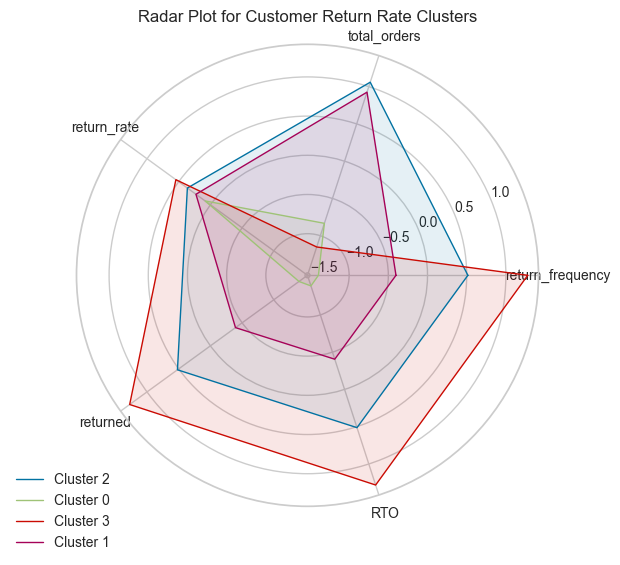

In [327]:
from math import pi

# Set data for radar plot
categories = list(d1.columns[1:])  # Ignore 'return_rate_Cluster'
N = len(categories)

# Create radar plot for each cluster
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i in range(len(d1)):
    values = d1.iloc[i, 1:].values.flatten().tolist()
    values += values[:1]  # Repeat the first value at the end to close the polygon
    # Compute angle for each axis
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {d1["return_rate_Cluster"][i]}')
    ax.fill(angles, values, alpha=0.1)

# Add labels to the plot
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.title('Radar Plot for Customer Return Rate Clusters')
plt.show()


In [328]:
for i in ['return_rate']:
    column = i
    print(column)
    for j in range(0,4):
        print(f"Score {j} ranges from : {data[column][data[f'{column}_Cluster'] == j].min()} to {data[column][data[f'{column}_Cluster'] == j].max()}")

return_rate
Score 0 ranges from : 0.0 to 0.15384615384615385
Score 1 ranges from : 0.15789473684210525 to 0.2916666666666667
Score 2 ranges from : 0.29411764705882354 to 0.4444444444444444
Score 3 ranges from : 0.45 to 1.0


In [329]:
average_order_value_per_user = df.groupby('user_id')['order_value'].mean().reset_index()
average_order_value_per_user.columns = ['user_id', 'average_order_value']
average_order_value_per_user

,user_id,average_order_value
0,1,2660.26
1,2,1991.14
2,3,1793.49
3,4,2359.27
4,5,2722.80
...,...,...
99984,99996,2631.61
99985,99997,3456.92
99986,99998,2182.12
99987,99999,2460.45


In [330]:
df['order_date'] = pd.to_datetime(df['order_date'])
df = df.sort_values(by=['user_id', 'order_date'])
df['previous_order_date'] = df.groupby('user_id')['order_date'].shift(1)
df['time_between_orders'] = (df['order_date'] - df['previous_order_date']).dt.days
df

,order_id,order_date,user_id,order_value,category,quantity,order_status,supplier_id,feedback,clicks_count,app_open_count,is_returned,returned,RTO,return_rate,previous_order_date,time_between_orders
14727,14727,2023-12-23,1,1719.63,Clothing,3,delivered,865,Negative feedback,24,42,0,0,0,0.20,NaT,NaN
878424,878424,2024-01-13,1,3443.83,Electronics,4,delivered,221,Positive feedback,10,27,0,0,0,NaN,2023-12-23,21.00
632750,632750,2024-01-19,1,32.74,Clothing,2,cancelled,483,Negative feedback,23,40,0,0,0,NaN,2024-01-13,6.00
339707,339707,2024-01-31,1,4245.49,Clothing,9,exchanged,252,Negative feedback,2,32,0,0,0,NaN,2024-01-19,12.00
457213,457213,2024-02-23,1,2630.97,Home Goods,7,cancelled,252,Positive feedback,11,35,0,0,0,NaN,2024-01-31,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61556,61556,2024-03-03,100000,2895.58,Electronics,7,cancelled,230,Positive feedback,2,25,0,0,0,0.20,2024-02-03,29.00
46347,46347,2024-04-13,100000,3927.97,Clothing,4,RTO,539,Negative feedback,0,0,1,0,1,0.25,2024-03-03,41.00
359159,359159,2024-05-17,100000,658.23,Electronics,8,returned,165,Negative feedback,0,47,1,1,0,NaN,2024-04-13,34.00
99481,99481,2024-05-20,100000,4611.09,Home Goods,1,delivered,857,Negative feedback,35,41,0,0,0,0.33,2024-05-17,3.00


In [331]:
# Ensure that only delivered / exchanged orders are accounted for monetary calculation
ltv_per_user = df[df['order_status'].isin(['delivered', 'exchanged'])]
ltv_per_user = ltv_per_user.groupby('user_id').agg({'order_value' : 'sum'}).reset_index()
ltv_per_user.columns = ['user_id', 'lifetime_value']
ltv_per_user

,user_id,lifetime_value
0,1,18845.53
1,2,7088.22
2,3,6241.12
3,4,13920.68
4,5,6851.89
...,...,...
98462,99996,9310.30
98463,99997,5169.92
98464,99998,9319.30
98465,99999,7943.73


In [332]:
return_rate_by_category = df.groupby('category')['is_returned'].mean().reset_index()
return_rate_by_category.columns = ['category', 'return_rate']
return_rate_by_category

,category,return_rate
0,Clothing,0.28
1,Electronics,0.28
2,Home Goods,0.28


In [333]:
return_rate_per_supplier = df.groupby('supplier_id')['is_returned'].mean().reset_index()
return_rate_per_supplier.columns = ['supplier_id', 'return_rate']
return_rate_per_supplier

,supplier_id,return_rate
0,1,0.28
1,2,0.28
2,3,0.29
3,4,0.28
4,5,0.27
...,...,...
995,996,0.28
996,997,0.28
997,998,0.27
998,999,0.26


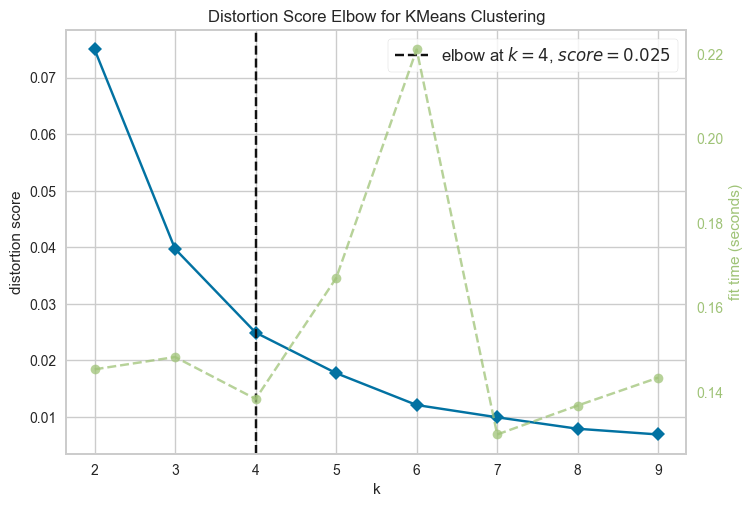

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [334]:
km = KMeans(random_state = 42)
visualizer = KElbowVisualizer(km, k = (2,10))
visualizer.fit(return_rate_per_supplier[['return_rate']])
visualizer.show()

In [335]:
# Create a new column to indicate if an order was returned
df2['is_returned'] = df2['order_status'].apply(lambda x: 1 if x == 'returned' or x == 'RTO' else 0)
df2['returned'] = df2['order_status'].apply(lambda x: 1 if x == 'returned' else 0)
df2['RTO'] = df2['order_status'].apply(lambda x: 1 if x == 'RTO' else 0)

# Calculate the number of returned orders per supplier
return_frequency_per_supplier = df2.groupby('supplier_id')['is_returned'].sum().reset_index()
return_frequency_per_supplier.columns = ['supplier_id', 'return_frequency']

# Calculate the total number of orders per supplier
total_orders_per_supplier = df2.groupby('supplier_id')['order_id'].count().reset_index()
total_orders_per_supplier.columns = ['supplier_id', 'total_orders']

# Merge the two DataFrames to calculate the return rate
return_rate_per_supplier = pd.merge(return_frequency_per_supplier, total_orders_per_supplier, on='supplier_id')

# Calculate return rate: number of returned orders / total orders
return_rate_per_supplier['return_rate'] = return_rate_per_supplier['return_frequency'] / return_rate_per_supplier['total_orders']

df2['return_rate'] = return_rate_per_supplier['return_rate']

f1 = df2.groupby('supplier_id')['returned'].sum().reset_index()
return_rate_per_supplier['returned'] = f1['returned']
f2 = df2.groupby('supplier_id')['RTO'].sum().reset_index()
return_rate_per_supplier['RTO'] = f2['RTO']


# Display the result
return_rate_per_supplier


,supplier_id,return_frequency,total_orders,return_rate,returned,RTO
0,1,281,1019,0.28,96,185
1,2,281,1018,0.28,103,178
2,3,281,979,0.29,103,178
3,4,269,949,0.28,94,175
4,5,266,968,0.27,94,172
...,...,...,...,...,...,...
995,996,267,964,0.28,92,175
996,997,268,962,0.28,86,182
997,998,268,995,0.27,95,173
998,999,262,1007,0.26,99,163


In [336]:
data = return_rate_per_supplier
# Select the columns you want to apply KMeans on
columns = ['return_rate']

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns])

# Initialize an empty dictionary to store the cluster scores for each column
cluster_scores = {}

# Apply KMeans clustering for each feature
for i, column in enumerate(columns):
    kmeans = KMeans(n_clusters=4, random_state=0)  # Use n_clusters=4 or any number based on your preference
    data[f'{column}_Cluster'] = kmeans.fit_predict(data_scaled[:, i].reshape(-1, 1))
    
    # Store the cluster labels
    cluster_scores[column] = data[f'{column}_Cluster']

# Print the dataframe with cluster labels
data

,supplier_id,return_frequency,total_orders,return_rate,returned,RTO,return_rate_Cluster
0,1,281,1019,0.28,96,185,0
1,2,281,1018,0.28,103,178,0
2,3,281,979,0.29,103,178,2
3,4,269,949,0.28,94,175,2
4,5,266,968,0.27,94,172,0
...,...,...,...,...,...,...,...
995,996,267,964,0.28,92,175,0
996,997,268,962,0.28,86,182,0
997,998,268,995,0.27,95,173,0
998,999,262,1007,0.26,99,163,3


In [343]:
d1 = data.groupby('return_rate_Cluster')\
                        .agg({'return_frequency':'mean','total_orders':'mean','return_rate':'mean','returned':'mean','RTO':'mean'}).reset_index()
d1['return_rate_Cluster'] = d1['return_rate_Cluster'].map({0:1,1:3,2:2,3:0})
data['return_rate_Cluster'] = data['return_rate_Cluster'].map({0:1,1:3,2:2,3:0})

# Columns to normalize
cols_to_normalize = ['return_frequency','total_orders','returned', 'RTO']

# Apply MinMaxScaler to normalize between 0 and 1
scaler = StandardScaler()
d1[cols_to_normalize] = scaler.fit_transform(d1[cols_to_normalize])
d1

,return_rate_Cluster,return_frequency,total_orders,return_rate,returned,RTO
0,1,-0.37,1.24,0.27,-0.32,-0.39
1,3,1.31,-0.77,0.30,1.29,1.32
2,2,0.45,0.70,0.29,0.45,0.45
3,0,-1.39,-1.17,0.26,-1.42,-1.38


In [344]:
for i in ['return_rate']:
    column = i
    print(column)
    for j in range(0,4):
        print(f"Score {j} ranges from : {data[column][data[f'{column}_Cluster'] == j].min()} to {data[column][data[f'{column}_Cluster'] == j].max()}")

return_rate
Score 0 ranges from : 0.22805247225025227 to 0.26715176715176714
Score 1 ranges from : 0.2672322375397667 to 0.2818270165208941
Score 2 ranges from : 0.2818991097922849 to 0.29678068410462777
Score 3 ranges from : 0.2970195272353546 to 0.3280475718533201


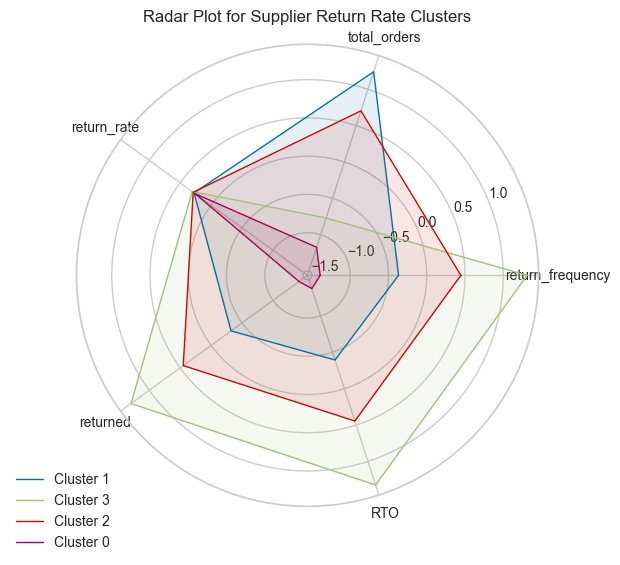

In [345]:
from math import pi

# Set data for radar plot
categories = list(d1.columns[1:])  # Ignore 'return_rate_Cluster'
N = len(categories)

# Create radar plot for each cluster
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i in range(len(d1)):
    values = d1.iloc[i, 1:].values.flatten().tolist()
    values += values[:1]  # Repeat the first value at the end to close the polygon
    # Compute angle for each axis
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {d1["return_rate_Cluster"][i]}')
    ax.fill(angles, values, alpha=0.1)

# Add labels to the plot
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.title('Radar Plot for Supplier Return Rate Clusters')
plt.show()


In [299]:
df['order_month'] = df['order_date'].dt.month
df['order_quarter'] = df['order_date'].dt.quarter
seasonal_return_trends = df.groupby(['order_month', 'order_quarter'])['is_returned'].mean().reset_index()
seasonal_return_trends

,order_month,order_quarter,is_returned
0,1,1,0.28
1,2,1,0.28
2,3,1,0.28
3,4,2,0.28
4,5,2,0.28
5,6,2,0.28
6,7,3,0.28
7,8,3,0.28
8,9,3,0.28
9,10,4,0.28


In [300]:
# Function to calculate RFM
def calculate_rfm(df, customer_id_col, order_id_col, order_date_col, order_value_col, snapshot_date=None):
    """
    Calculate RFM (Recency, Frequency, and Monetary) values for customers.

    Parameters:
    df (pd.DataFrame): DataFrame containing customer data.
    customer_id_col (str): The column name for the customer ID.
    order_date_col (str): The column name for the order date.
    order_value_col (str): The column name for the order value.
    snapshot_date (str or datetime, optional): The date to calculate recency against (default is today).

    Returns:
    pd.DataFrame: DataFrame with customer_id, Recency, Frequency, and Monetary values.
    """

    # Set the snapshot date (for recency calculation), default is today if not provided
    if snapshot_date is None:
        snapshot_date = datetime.today()
    else:
        snapshot_date = pd.to_datetime(snapshot_date)
    
    # Ensure the order_date_col is in datetime format
    df[order_date_col] = pd.to_datetime(df[order_date_col])
    
    # Ensure that only delivered / exchanged orders are accounted for monetary calculation
    filtered_df = df[df['order_status'].isin(['delivered', 'exchanged'])]
    filtered_df = filtered_df.groupby(customer_id_col).agg({order_value_col : 'sum'}).reset_index()

    # Calculate Recency: difference between the snapshot date and the last order date
    rfm_df = df.groupby(customer_id_col).agg({
        order_date_col: lambda x: (snapshot_date - x.max()).days,  # Recency
        order_id_col: 'count',  # Frequency
    }).reset_index()
    
    # Merging the DataFrames on 'user_id'
    merged_df = pd.merge(rfm_df, filtered_df, on=customer_id_col, how='left')

    # Replacing NaN values with 0
    merged_df[order_value_col] = merged_df[order_value_col].fillna(0)

    # Rename columns to Recency, Frequency, and Monetary
    merged_df.columns = [customer_id_col, 'Recency', 'Frequency', 'Monetary']

    return merged_df

In [301]:
# Function to map feedback and calculate the weighted feedback score
def calculate_feedback(df, customer_id_col, feedback_col, feedback_date_col, today, recent_threshold=30, alpha=0.7, beta=0.3):
    """
    Function to map feedback to a numerical score and calculate weighted feedback based on recency.
    
    Parameters:
    df (pd.DataFrame): The input dataframe with feedback data.
    customer_id_col (str): The column name for the customer ID.
    feedback_col (str): Column name for feedback (positive/negative/neutral).
    feedback_date_col (str): Column name for feedback date.
    today (str): The last date / latest date wrt which the recency will be calculated.
    recent_threshold (int): Number of days to classify feedback as 'recent'. Default is 30 days.
    alpha (float): Weight for recent feedback. Default is 0.7.
    beta (float): Weight for older feedback. Default is 0.3.
    
    Returns:
    pd.DataFrame: DataFrame with the weighted feedback scores.
    """

    # Step 1: Map the feedback to numerical scores
    feedback_mapping = {
        'Positive feedback': 1,
        'Neutral feedback': 0,
        'Negative feedback': -1
    }
    df['feedback_mapped'] = df[feedback_col].map(feedback_mapping)
    
    # Convert feedback_date_col to datetime if not already
    df[feedback_date_col] = pd.to_datetime(df[feedback_date_col])
    
    # Step 2: Calculate days since feedback was provided
    if not today :
        today = pd.to_datetime("today")
    df['days_since_feedback'] = (today - df[feedback_date_col]).dt.days
    
    # Step 3: Classify feedback as 'recent' or 'older'
    df['feedback_type'] = df['days_since_feedback'].apply(lambda x: 'recent' if x <= recent_threshold else 'older')
    
    # Step 4: Calculate the weighted feedback score based on recency
    df['weighted_feedback'] = df.apply(lambda x: alpha * x['feedback_mapped'] if x['feedback_type'] == 'recent' 
                                       else beta * x['feedback_mapped'], axis=1)
    
    # Step 5: Group the by customer_id and sum the weighted scores
    feedback_df = df.groupby(customer_id_col).agg({
        'weighted_feedback': 'sum'
    }).reset_index()

    # Rename columns to Recency, Frequency, and Monetary
    feedback_df.columns = [customer_id_col, 'Weighted Feedback Score']
    
    return feedback_df

In [158]:
# Function to map feedback and calculate the weighted feedback score
def calculate_interaction(df, customer_id_col, clicks_count_col, app_open_count_col, alpha=1, beta=2):
    """
    Function to map feedback to a numerical score and calculate weighted feedback based on recency.
    
    Parameters:
    df (pd.DataFrame): The input dataframe with feedback data.
    customer_id_col (str): The column name for the customer ID.
    clicks_count_col (str): Column name for number of clicks.
    app_open_count_col (str): Column name for number of times the app was opened.
    alpha (float): Weight for app opens. Default is 1.
    beta (float): Weight for clicks. Default is 2.
    
    Returns:
    pd.DataFrame: DataFrame with the weighted feedback scores.
    """

    
    # Step 4: Calculate the weighted feedback score based on recency
    df['weighted_interaction_score'] = df.apply(lambda x: alpha * x[app_open_count_col] + beta * x[clicks_count_col], axis=1)
    
    # Step 5: Group the by customer_id and sum the weighted scores
    interaction_df = df.groupby(customer_id_col).agg({
        'weighted_interaction_score': 'sum'
    }).reset_index()

    # Rename columns to Recency, Frequency, and Monetary
    interaction_df.columns = [customer_id_col, 'Weighted Interaction Score']
    
    return interaction_df

In [159]:
max_date = df['order_date'].max()
x = calculate_rfm(df,'user_id','order_id','order_date','order_value',max_date)
y = calculate_feedback(df,'user_id','feedback','order_date',max_date)
z = calculate_interaction(df,'user_id','clicks_count','app_open_count')
x['Feedback'] = y['Weighted Feedback Score']
x['Interaction'] = z['Weighted Interaction Score']
x

,user_id,Recency,Frequency,Monetary,Feedback,Interaction
0,1,17,14,18845.53,-1.20,803
1,2,6,13,7088.22,1.00,580
2,3,12,8,6241.12,-0.80,465
3,4,42,14,13920.68,-2.10,822
4,5,6,9,6851.89,-2.20,201
...,...,...,...,...,...,...
99984,99996,0,10,9310.30,-1.00,516
99985,99997,13,8,5169.92,-1.60,355
99986,99998,44,11,9319.30,-1.20,694
99987,99999,23,12,7943.73,-0.40,764


In [218]:
data = x
# Select the columns you want to apply KMeans on
columns = ['Recency', 'Frequency', 'Monetary', 'Feedback', 'Interaction']

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns])

# Initialize an empty dictionary to store the cluster scores for each column
cluster_scores = {}

# Apply KMeans clustering for each feature
for i, column in enumerate(columns):
    kmeans = KMeans(n_clusters=4, random_state=0)  # Use n_clusters=4 or any number based on your preference
    data[f'{column}_Cluster'] = kmeans.fit_predict(data_scaled[:, i].reshape(-1, 1))
    
    # Store the cluster labels
    cluster_scores[column] = data[f'{column}_Cluster']

# Print the dataframe with cluster labels
data

,user_id,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,Feedback_Cluster,Interaction_Cluster,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score
0,1,17,14,18845.53,-1.20,803,0,0,3,0,1,3,2,3,1,3
1,2,6,13,7088.22,1.00,580,0,0,0,3,3,3,2,1,3,2
2,3,12,8,6241.12,-0.80,465,0,2,1,0,0,3,1,0,1,1
3,4,42,14,13920.68,-2.10,822,2,0,2,1,1,2,2,2,0,3
4,5,6,9,6851.89,-2.20,201,0,2,0,1,2,3,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99984,99996,0,10,9310.30,-1.00,516,0,2,0,0,3,3,1,1,1,2
99985,99997,13,8,5169.92,-1.60,355,0,2,1,1,0,3,1,0,0,1
99986,99998,44,11,9319.30,-1.20,694,2,0,0,0,3,2,2,1,1,2
99987,99999,23,12,7943.73,-0.40,764,0,0,0,2,1,3,2,1,2,3


In [219]:
mapping = {
    0: 3,
    2: 2,
    3: 1,
    1: 0
}
data['Recency_Score'] = data['Recency_Cluster'].map(mapping)
mapping = {
    3: 3,
    0: 2,
    2: 1,
    1: 0
}
data['Frequency_Score'] = data['Frequency_Cluster'].map(mapping)
mapping = {
    3: 3,
    2: 2,
    0: 1,
    1: 0
}
data['Monetary_Score'] = data['Monetary_Cluster'].map(mapping)
mapping = {
    3: 3,
    2: 2,
    0: 1,
    1: 0
}
data['Feedback_Score'] = data['Feedback_Cluster'].map(mapping)
mapping = {
    1: 3,
    3: 2,
    2: 0,
    0: 1
}
data['Interaction_Score'] = data['Interaction_Cluster'].map(mapping)
data

,user_id,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,Feedback_Cluster,Interaction_Cluster,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score
0,1,17,14,18845.53,-1.20,803,0,0,3,0,1,3,2,3,1,3
1,2,6,13,7088.22,1.00,580,0,0,0,3,3,3,2,1,3,2
2,3,12,8,6241.12,-0.80,465,0,2,1,0,0,3,1,0,1,1
3,4,42,14,13920.68,-2.10,822,2,0,2,1,1,2,2,2,0,3
4,5,6,9,6851.89,-2.20,201,0,2,0,1,2,3,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99984,99996,0,10,9310.30,-1.00,516,0,2,0,0,3,3,1,1,1,2
99985,99997,13,8,5169.92,-1.60,355,0,2,1,1,0,3,1,0,0,1
99986,99998,44,11,9319.30,-1.20,694,2,0,0,0,3,2,2,1,1,2
99987,99999,23,12,7943.73,-0.40,764,0,0,0,2,1,3,2,1,2,3


In [263]:
copy = data[['user_id','Recency','Frequency','Monetary','Feedback','Interaction','Recency_Score','Frequency_Score','Monetary_Score','Feedback_Score','Interaction_Score']]
copy['Overall_Score'] = (
    copy['Recency_Score'] +
    copy['Frequency_Score'] +
    copy['Monetary_Score'] +
    copy['Feedback_Score'] +
    copy['Interaction_Score']
)
copy

,user_id,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score
0,1,17,14,18845.53,-1.20,803,3,2,3,1,3,12
1,2,6,13,7088.22,1.00,580,3,2,1,3,2,11
2,3,12,8,6241.12,-0.80,465,3,1,0,1,1,6
3,4,42,14,13920.68,-2.10,822,2,2,2,0,3,9
4,5,6,9,6851.89,-2.20,201,3,1,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
99984,99996,0,10,9310.30,-1.00,516,3,1,1,1,2,8
99985,99997,13,8,5169.92,-1.60,355,3,1,0,0,1,5
99986,99998,44,11,9319.30,-1.20,694,2,2,1,1,2,8
99987,99999,23,12,7943.73,-0.40,764,3,2,1,2,3,11


In [264]:
for i in ['Recency', 'Frequency', 'Monetary', 'Feedback', 'Interaction']:
    column = i
    print(column)
    for j in range(0,4):
        print(f"Score {j} ranges from : {copy[column][copy[f'{column}_Score'] == j].min()} to {copy[column][copy[f'{column}_Score'] == j].max()}")

Recency
Score 0 ranges from : 121 to 361
Score 1 ranges from : 63 to 120
Score 2 ranges from : 27 to 62
Score 3 ranges from : 0 to 26
Frequency
Score 0 ranges from : 1 to 7
Score 1 ranges from : 8 to 10
Score 2 ranges from : 11 to 14
Score 3 ranges from : 15 to 25
Monetary
Score 0 ranges from : 0.0 to 6535.34
Score 1 ranges from : 6535.360000000001 to 12027.0
Score 2 ranges from : 12027.21 to 18534.19
Score 3 ranges from : 18535.41 to 41488.58
Feedback
Score 0 ranges from : -5.6 to -1.5
Score 1 ranges from : -1.4 to -0.5999999999999999
Score 2 ranges from : -0.5 to 0.19999999999999996
Score 3 ranges from : 0.29999999999999993 to 3.0
Interaction
Score 0 ranges from : 1 to 340
Score 1 ranges from : 341 to 511
Score 2 ranges from : 512 to 706
Score 3 ranges from : 707 to 1496


In [265]:
copy['return_rate'] = return_rate_per_user['return_rate']
copy.set_index('user_id',inplace = True)
copy = copy[(copy['return_rate'] > 0)& (copy['return_rate'] < 1)]
copy

,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score,return_rate
user_id,,,,,,,,,,,,
1,17,14,18845.53,-1.20,803,3,2,3,1,3,12,0.14
2,6,13,7088.22,1.00,580,3,2,1,3,2,11,0.46
3,12,8,6241.12,-0.80,465,3,1,0,1,1,6,0.38
4,42,14,13920.68,-2.10,822,2,2,2,0,3,9,0.36
5,6,9,6851.89,-2.20,201,3,1,1,0,0,5,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...
99996,0,10,9310.30,-1.00,516,3,1,1,1,2,8,0.30
99997,13,8,5169.92,-1.60,355,3,1,0,0,1,5,0.62
99998,44,11,9319.30,-1.20,694,2,2,1,1,2,8,0.18


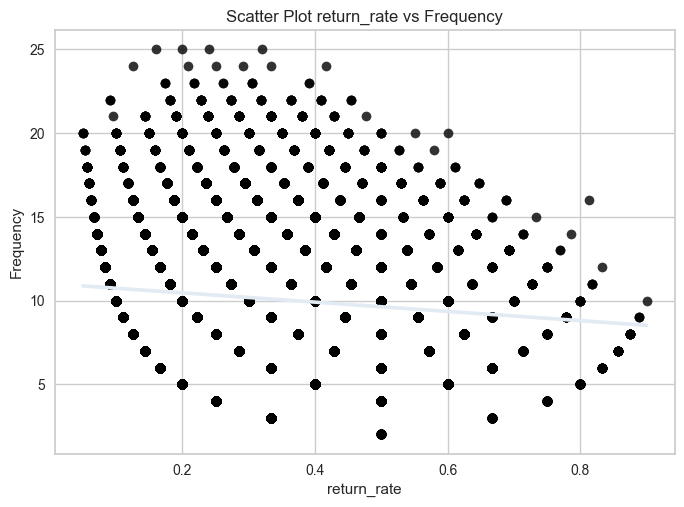

In [347]:
df = copy
# Columns to normalize
cols_to_normalize = ['Monetary','Recency', 'Frequency','Interaction','Feedback']

feature1 = 'return_rate'
feature2 = 'Frequency'

# Scatter plot with customized colors and black outlines
sns.regplot(x=feature1, y=feature2, data=df,
            scatter_kws={'color': 'black', 'edgecolor': 'white'},  # Color of the points and outline
            line_kws={'color': '#E2EAF4'})    # Color of the regression line

# Show plot
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title(f'Scatter Plot {feature1} vs {feature2}')
plt.show()


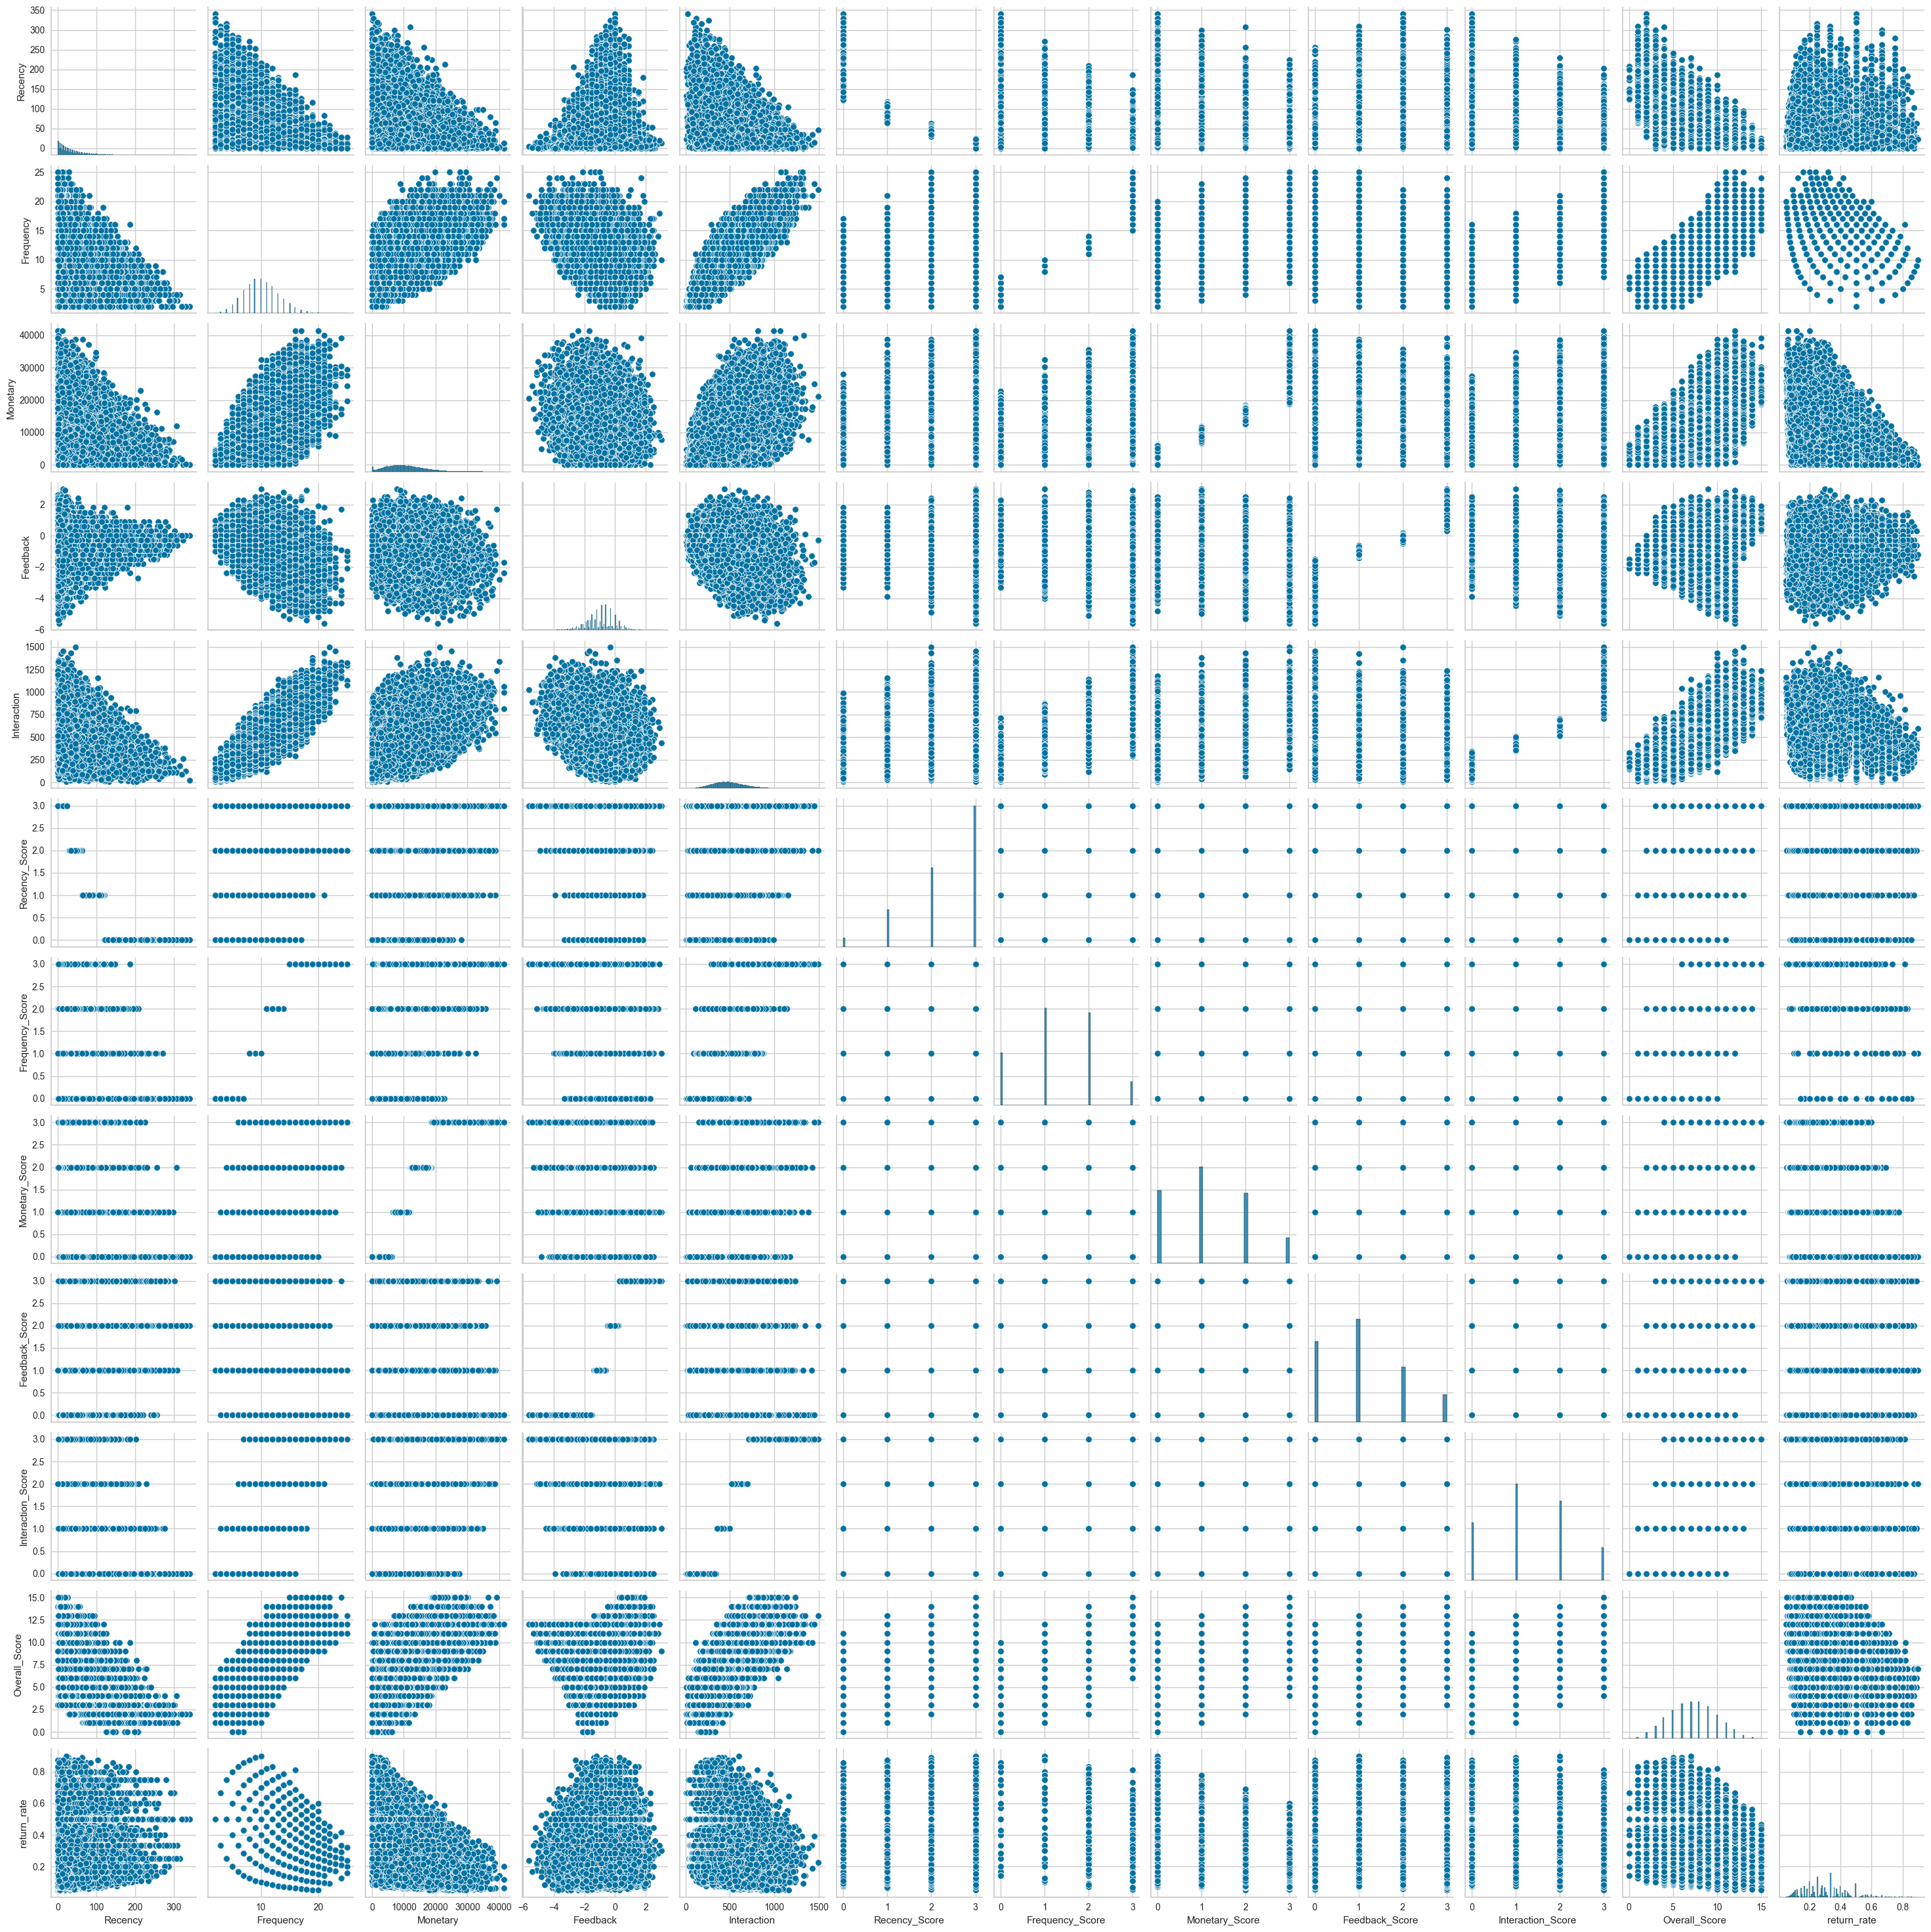

In [223]:
sns.pairplot(copy)

In [212]:
import pytimetk as tk
import pycaret.classification as clf
import pycaret.regression as reg
from pycaret.classification import *

In [213]:
# REGRESSION ---------
reg_setup = reg.setup(
            data = copy,#.drop('return_rate', axis = 1),
            target = 'return_rate',
            train_size = 0.8,
            normalize = True,
            session_id = 123,
            verbose = True,
            log_experiment = False)
xgb_reg_model = reg.create_model('xgboost')
reg_predictions_data = reg.predict_model(xgb_reg_model, data = copy)\
                       .sort_values('prediction_label', ascending = False)

,Description,Value
0,Session id,123
1,Target,return_rate
2,Target type,Regression
3,Original data shape,"(99989, 12)"
4,Transformed data shape,"(99989, 12)"
5,Transformed train set shape,"(79991, 12)"
6,Transformed test set shape,"(19998, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1093,0.0193,0.1391,0.1454,0.1083,0.4350
1,0.1094,0.0192,0.1384,0.1342,0.1084,0.4402
2,0.1092,0.0192,0.1386,0.1627,0.1075,0.4403
3,0.1085,0.0190,0.1378,0.1438,0.1078,0.4364
4,0.1064,0.0184,0.1356,0.1627,0.1058,0.4261
5,0.1082,0.0189,0.1375,0.1791,0.1067,0.4239
6,0.1100,0.0196,0.1398,0.1632,0.1087,0.4294
7,0.1101,0.0195,0.1395,0.1470,0.1086,0.4346
8,0.1119,0.0199,0.1410,0.1461,0.1099,0.4582


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.1030,0.0169,0.1300,0.2587,0.1015,0.4154


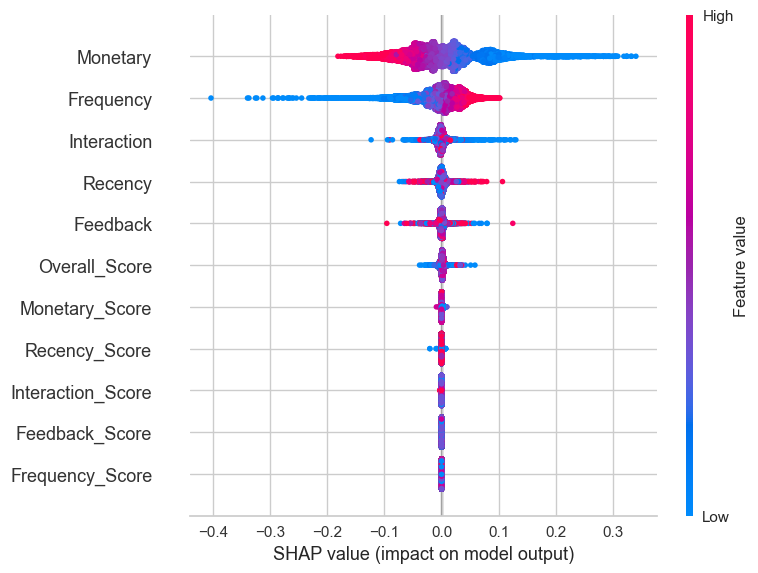

In [214]:
reg.interpret_model(xgb_reg_model)

In [215]:
return_rate_per_rfm = copy.groupby('Overall_Score')['return_rate'].mean().reset_index()
return_rate_per_rfm.columns = ['Recency_Score', 'return_rate']
return_rate_per_rfm

,Recency_Score,return_rate
0,0,0.36
1,1,0.32
2,2,0.31
3,3,0.31
4,4,0.30
5,5,0.29
6,6,0.29
7,7,0.28
8,8,0.27
9,9,0.27
